# **Exoplanets, Kepler Confirmed Planets and Solar System Planets!**

*Author: Anton Zaitsev*  
*Date: November 24, 2023*

---------

# Data

## NASA Exoplanet Archive

https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=PS

## Solar System Major Bodies Data

https://www.kaggle.com/datasets/jaredsavage/solar-system-major-bodies-data

## Kepler Confirmed Planets

https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=kep_conf_names


## Data Description

### NASA Exoplanet Archive

NASA Exoplanet Archive dataset contains information on confirmed planets outside of the Solar System, e.g. planet mass, radius, planet discovery method, orbital period, etc.

Rows: 35131
Columns: 286

### Solar System Major Bodies Data

The Solar System Planets dataset contains information on major bodies inside the Solar System, including planets, such as Earth, Mars, Venus, etc. It includes information on body's attributes, such as mass, density, etc.

Rows: 31
Columns: 265

### Kepler Confirmed Planets

The Kepler Confirmed Planets dataset includes information about exoplanets that have been confirmed through observations by NASA's Kepler mission. Kepler-confirmed planets are those KOIs that have undergone further scrutiny and have been confirmed as actual exoplanets through additional observations. The confirmation process aims to rule out false positives and confirm that the observed signals are consistent with the presence of planets.

Rows: 2807
Columns: 4

## Which Data will be Used?


### NASA Exoplanet Archive

Columns:

```
Planet Name, Host Name, Discovery Year, Discovery Method, Controversial Flag, Number of Stars, Number of Planets, Number of Moons, Orbital Period [days], Planet Radius [Earth Radius], Planet Mass [Earth Mass], Planet Eccentricity, Planet Density [g/cm3], Eccentricity, Insolation Flux [Earth Flux], Equilibrium Temperature [K], Inclination [deg], Stellar Effective Temperature [K], Stellar Radius [Solar Radius], Stellar Mass [Solar mass], Stellar Luminosity [log(Solar)], Stellar Surface Gravity [log10(cm/s2)], Stellar Age [Gyr], Stellar Density [g/cm**3], Distance [pc]
```

---------



# Imports

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


---------

# Global Variables

In [27]:
EXOPLANETS_PATH = 'data/exoplanets.csv'
EXOPLANETS_HEADER = 290
SOLARPLANETS_URL = 'data/solarplanets.csv'
KEPLER_PATH = 'data/kepler.csv'
KEPLER_HEADER = 8


---------

# Data Engineering

## Exoplanets

In [28]:
descriptions = pd.read_csv(EXOPLANETS_PATH, nrows=EXOPLANETS_HEADER - 1)[2:-1].iloc[:, 0].tolist()
descriptions_clear = [description.split(':')[1].strip() for description in descriptions]
print(descriptions_clear[:5])
print(descriptions_clear[49:53])


['Planet Name', 'Host Name', 'Planet Letter', 'HD ID', 'HIP ID']
['Planet Mass [Earth Mass]', 'Planet Mass [Earth Mass] Upper Unc.', 'Planet Mass [Earth Mass] Lower Unc.', 'Planet Mass [Earth Mass] Limit Flag']


In [29]:
columns_considered = [
    'pl_name', 'hostname', 'disc_year', 'discoverymethod', 
    'pl_controv_flag', 'sy_snum', 'sy_pnum', 'sy_mnum',
    'pl_orbper', 'pl_rade', 'pl_masse', 'pl_dens',
    'pl_orbeccen', 'pl_insol', 'pl_eqt', 'pl_orbincl',
    'st_teff', 'st_rad', 'st_mass', 'st_lum', 
    'st_logg', 'st_age', 'st_dens', 'sy_dist', 'pl_orbsmax',
]
exoplanets_dirty = pd.read_csv(EXOPLANETS_PATH, header=EXOPLANETS_HEADER, usecols=columns_considered, index_col=None)
exoplanets_dirty


,pl_name,hostname,sy_snum,sy_pnum,sy_mnum,discoverymethod,disc_year,pl_controv_flag,pl_orbper,pl_orbsmax,...,pl_eqt,pl_orbincl,st_teff,st_rad,st_mass,st_lum,st_logg,st_age,st_dens,sy_dist
0,11 Com b,11 Com,2,1,0,Radial Velocity,2007,0,NaN,1.210,...,NaN,NaN,NaN,NaN,2.60,NaN,NaN,NaN,NaN,93.1846
1,11 Com b,11 Com,2,1,0,Radial Velocity,2007,0,326.03000,1.290,...,NaN,NaN,4742.0,19.00,2.70,2.243,2.31,NaN,NaN,93.1846
2,11 Com b,11 Com,2,1,0,Radial Velocity,2007,0,323.21000,1.178,...,NaN,NaN,4874.0,13.76,2.09,1.978,2.45,NaN,NaN,93.1846
3,11 UMi b,11 UMi,1,1,0,Radial Velocity,2009,0,516.21997,1.530,...,NaN,NaN,4213.0,29.79,2.78,NaN,1.93,NaN,NaN,125.3210
4,11 UMi b,11 UMi,1,1,0,Radial Velocity,2009,0,NaN,1.510,...,NaN,NaN,NaN,NaN,1.70,NaN,NaN,NaN,NaN,125.3210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35126,ups And d,ups And,2,3,0,Radial Velocity,1999,0,1319.00000,2.570,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.4054
35127,ups Leo b,ups Leo,1,1,0,Radial Velocity,2021,0,385.20000,1.180,...,NaN,NaN,4836.0,11.22,1.48,1.800,2.46,NaN,NaN,52.5973
35128,xi Aql b,xi Aql,1,1,0,Radial Velocity,2007,0,NaN,0.580,...,NaN,NaN,NaN,NaN,1.40,NaN,NaN,NaN,NaN,56.1858
35129,xi Aql b,xi Aql,1,1,0,Radial Velocity,2007,0,136.75000,0.680,...,NaN,NaN,4780.0,12.00,2.20,1.839,2.66,NaN,NaN,56.1858


Some planets are discovered by different facilities. We need to group the planets by planet name.

In [30]:
columns_group = ['pl_name', 'hostname', 'disc_year', 'discoverymethod']
exoplanets = exoplanets_dirty.groupby(columns_group).mean()
exoplanets = exoplanets.reset_index()

exoplanets


,pl_name,hostname,disc_year,discoverymethod,sy_snum,sy_pnum,sy_mnum,pl_controv_flag,pl_orbper,pl_orbsmax,...,pl_eqt,pl_orbincl,st_teff,st_rad,st_mass,st_lum,st_logg,st_age,st_dens,sy_dist
0,11 Com b,11 Com,2007,Radial Velocity,2.0,1.0,0.0,0.0,324.620000,1.226000,...,NaN,NaN,4808.000000,16.380000,2.463333,2.1105,2.3800,NaN,NaN,93.1846
1,11 UMi b,11 UMi,2009,Radial Velocity,1.0,1.0,0.0,0.0,516.219985,1.526667,...,NaN,NaN,4276.500000,26.935000,2.093333,NaN,1.7650,1.560000,NaN,125.3210
2,14 And b,14 And,2008,Radial Velocity,1.0,1.0,0.0,0.0,186.300000,0.761667,...,NaN,NaN,4850.500000,11.275000,1.726667,1.8015,2.5900,NaN,NaN,75.4392
3,14 Her b,14 Her,2002,Radial Velocity,1.0,2.0,0.0,0.0,1766.378417,2.814750,...,NaN,144.652,5296.985000,0.976667,0.927143,-0.1515,4.4200,3.900000,1.2739,17.9323
4,16 Cyg B b,16 Cyg B,1996,Radial Velocity,3.0,1.0,0.0,0.0,799.375000,1.662833,...,NaN,NaN,5728.594000,1.140000,1.016000,0.0970,4.3440,NaN,1.0110,21.1397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5534,ups And b,ups And,1996,Radial Velocity,2.0,3.0,0.0,0.0,4.616229,0.058895,...,NaN,NaN,6137.820000,1.615000,1.250000,0.5250,4.1625,3.706667,0.3699,13.4054
5535,ups And c,ups And,1999,Radial Velocity,2.0,3.0,0.0,0.0,240.728533,0.827712,...,NaN,NaN,6117.093333,1.615000,1.262500,0.5250,4.1500,4.060000,0.3699,13.4054
5536,ups And d,ups And,1999,Radial Velocity,2.0,3.0,0.0,0.0,1285.346167,2.528382,...,NaN,NaN,6117.093333,1.615000,1.262500,0.5250,4.1500,4.060000,0.3699,13.4054
5537,ups Leo b,ups Leo,2021,Radial Velocity,1.0,1.0,0.0,0.0,385.200000,1.180000,...,NaN,NaN,4836.000000,11.220000,1.480000,1.8000,2.4600,NaN,NaN,52.5973


## Solar Planets

In [31]:
solar_bodies = pd.read_csv(SOLARPLANETS_URL)
solar_bodies


,eName,isPlanet,semimajorAxis,perihelion,aphelion,eccentricity,inclination,density,gravity,escape,...,orbits,bondAlbido,geomAlbido,RV_abs,p_transit,transit_visibility,transit_depth,massj,semimajorAxis_AU,grav_int
0,Moon,False,384400,363300,405500,0.0549,5.145,3.344,1.6200,2380.000,...,Earth,NaN,NaN,NaN,1.811589,326.086108,2.245860e-09,3.868421e-05,0.002570,6.606324e+25
1,Phobos,False,9376,9234,9518,0.0151,1.075,1.900,0.0057,11.390,...,Mars,NaN,NaN,NaN,74.272078,13368.973976,2.245860e-09,5.578947e-12,0.000063,1.601437e+22
2,Deimos,False,23458,23456,23471,0.0002,1.075,1.750,0.0030,5.556,...,Mars,NaN,NaN,NaN,29.686035,5343.486231,2.245860e-09,1.263158e-12,0.000157,5.792534e+20
3,Io,False,421800,0,0,0.0040,0.036,3.530,1.7900,0.000,...,Jupiter,NaN,NaN,NaN,1.655200,297.936060,6.842474e-06,4.700000e-05,0.002820,6.666188e+25
4,Europa,False,671100,0,0,0.0090,0.466,3.010,1.3100,0.000,...,Jupiter,NaN,NaN,NaN,1.039939,187.188949,5.023997e-06,2.526316e-05,0.004486,1.415487e+25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,S/2017 J 8,False,23233000,0,0,0.3120,164.700,1.000,0.0000,0.000,...,Jupiter,NaN,NaN,NaN,0.029972,5.394983,5.155785e-13,1.263158e-11,0.155303,5.905272e+15
261,S/2017 J 9,False,21487000,0,0,0.2290,152.700,1.000,0.0000,0.000,...,Jupiter,NaN,NaN,NaN,0.032408,5.833380,4.640207e-12,1.263158e-11,0.143632,6.903971e+15
262,Ersa,False,11483000,0,0,0.0940,30.600,1.000,0.0000,0.000,...,Jupiter,NaN,NaN,NaN,0.060641,10.915425,4.640207e-12,1.263158e-11,0.076759,2.417351e+16
263,Ultima Thule,False,6633400000,0,0,0.0000,0.000,1.000,0.0000,0.000,...,NaN,NaN,NaN,NaN,0.000105,0.018896,2.245860e-09,1.263158e-11,44.341540,7.243995e+10


### Pick Relevant Planets

In [32]:
solarplanets_names = ['Mercury', 'Venus', 'Earth', 'Mars', 'Jupiter', 'Saturn', 'Uranus', 'Neptune']
solarplanets = solar_bodies[solar_bodies['eName'].isin(solarplanets_names)].reset_index()
solarplanets


,index,eName,isPlanet,semimajorAxis,perihelion,aphelion,eccentricity,inclination,density,gravity,...,orbits,bondAlbido,geomAlbido,RV_abs,p_transit,transit_visibility,transit_depth,massj,semimajorAxis_AU,grav_int
0,199,Uranus,True,2870658186,2147483647,2147483647,0.0457,0.772,1.2700,8.87,...,NaN,0.300,0.488,0.296744,0.000251,0.045253,0.001327,0.045684,19.189165,1.398930e+21
1,219,Neptune,True,4498396441,2147483647,2147483647,0.0113,1.769,1.6380,11.15,...,NaN,0.290,0.442,0.278582,0.000160,0.028849,0.001250,0.053684,30.069923,6.694590e+20
2,238,Jupiter,True,778340821,740379835,816620000,0.0489,1.304,1.3262,24.79,...,NaN,0.503,0.538,12.473518,0.000984,0.177205,0.010080,1.000000,5.202887,4.165367e+23
3,239,Mars,True,227943824,206700000,249200000,0.0935,1.850,3.9341,3.71,...,NaN,0.250,0.170,0.007785,0.003070,0.552556,0.000024,0.000338,1.523710,1.641038e+21
4,240,Mercury,True,57909227,46001200,69816900,0.2056,7.000,5.4291,3.70,...,NaN,0.088,0.142,0.007939,0.012067,2.172031,0.000012,0.000174,0.387099,1.306946e+22
5,241,Saturn,True,1426666422,1349823615,1503509229,0.0565,2.485,0.6871,10.44,...,NaN,0.342,0.499,2.752346,0.000529,0.095203,0.006993,0.298947,9.536676,3.706318e+22
6,243,Earth,True,149598262,147095000,152100000,0.0167,0.000,5.5136,9.80,...,NaN,0.306,0.367,0.089355,0.004697,0.845520,0.000084,0.003142,1.000003,3.542913e+22
7,244,Venus,True,108208475,107477000,108939000,0.0067,3.390,5.2430,8.87,...,NaN,0.760,0.689,0.085703,0.006491,1.168401,0.000076,0.002563,0.723329,5.523898e+22


## Kepler Planets

In [33]:
keplerplanets = pd.read_csv(KEPLER_PATH, header=KEPLER_HEADER, index_col=None)
keplerplanets


,kepid,koi_name,kepler_name,pl_name
0,11446443,K00001.01,Kepler-1 b,TrES-2 b
1,11904151,K00072.01,Kepler-10 b,Kepler-10 b
2,11904151,K00072.02,Kepler-10 c,Kepler-10 c
3,11904151,NaN,Kepler-10 d,Kepler-10 d
4,6521045,K00041.02,Kepler-100 b,Kepler-100 b
...,...,...,...,...
2802,4035640,K01881.01,Kepler-995 b,Kepler-995 b
2803,6205228,K01882.01,Kepler-996 b,Kepler-996 b
2804,11758544,K01883.01,Kepler-997 b,Kepler-997 b
2805,11413812,K01885.01,Kepler-998 b,Kepler-998 b


### Join Exoplanets and Kepler Confirmed Planets

In [34]:
exoplanets = exoplanets.copy() 
exoplanets['kepler_confirmed'] = exoplanets['pl_name'].isin(keplerplanets['pl_name'])
exoplanets['kepler_confirmed'] = exoplanets['kepler_confirmed'].astype(bool)
sum(exoplanets['kepler_confirmed'])


2807

---------

# Exploratory Analysis

## Number of Exoplanets Discovered by Year and Discovery Method

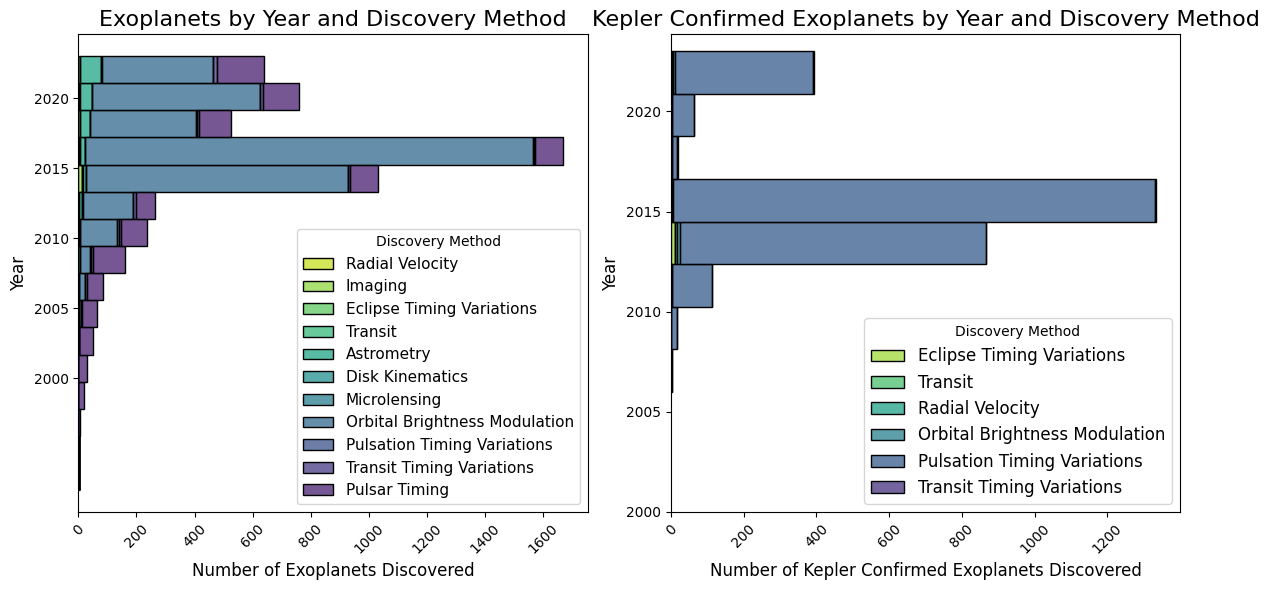

In [35]:
plt.figure(figsize=(12, 6))

ax1 = plt.subplot(1, 2, 1)
sns.histplot(
    data=exoplanets, 
    y='disc_year', 
    multiple="stack",
    binwidth=2, 
    hue='discoverymethod', 
    palette='viridis'
)
plt.title('Exoplanets by Year and Discovery Method', fontsize=16)
plt.xlabel('Number of Exoplanets Discovered',fontsize=12)
plt.ylabel('Year',fontsize=12)
plt.xticks(rotation=45)
plt.yticks(range(2000, max(exoplanets['disc_year'])+1, 5))
legend_labels = exoplanets['discoverymethod'].unique()
ax1.legend(labels=legend_labels, title='Discovery Method', fontsize=11)

ax2 = plt.subplot(1, 2, 2)
sns.histplot(
    data=exoplanets[exoplanets['kepler_confirmed']], 
    y='disc_year', 
    multiple="stack",
    binwidth=2, 
    hue='discoverymethod', 
    palette='viridis'
)
plt.title('Kepler Confirmed Exoplanets by Year and Discovery Method', fontsize=16)
plt.xlabel('Number of Kepler Confirmed Exoplanets Discovered',fontsize=12)
plt.ylabel('Year',fontsize=12)
plt.xticks(rotation=45)
plt.yticks(range(2000, max(exoplanets['disc_year'])+1, 5))
legend_labels_kepler = exoplanets[exoplanets['kepler_confirmed']]['discoverymethod'].unique()
ax2.legend(labels=legend_labels_kepler, title='Discovery Method', fontsize=12, loc='lower right')

plt.tight_layout()
plt.show()



# Is Exoplanet Controversial?

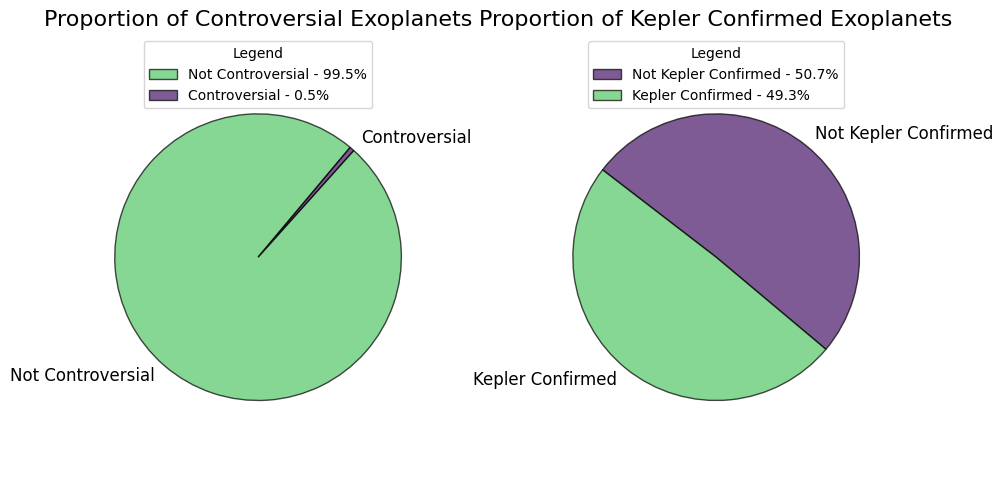

In [36]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
wedges, texts, autotexts = plt.pie(
    exoplanets['pl_controv_flag'].value_counts(), 
    labels=['Not Controversial', 'Controversial'], 
    autopct='', 
    colors=['#55C667FF', '#481567FF'],
    textprops={'fontsize': 12, 'color': 'black'}, 
    wedgeprops={'edgecolor': 'black', "alpha": 0.7},
    startangle=50
)
percs = exoplanets['pl_controv_flag'].value_counts(normalize=True)*100
labels = [f'{label} - {perc:.1f}%' for label, perc in zip(['Not Controversial', 'Controversial'], percs)]
plt.legend(
    wedges, 
    labels, 
    title='Legend', 
    bbox_to_anchor=(0.5, 1),
    loc='upper center'
)
plt.axis('equal')
plt.title('Proportion of Controversial Exoplanets', fontsize=16)

plt.subplot(1, 2, 2)
wedges, texts, autotexts = plt.pie(
    exoplanets['kepler_confirmed'].value_counts(), 
    labels=['Not Kepler Confirmed', 'Kepler Confirmed'], 
    autopct='', 
    colors=['#481567FF', '#55C667FF'],
    textprops={'fontsize': 12, 'color': 'black'}, 
    wedgeprops={'edgecolor': 'black', "alpha": 0.7},
    startangle=320
)
percs = exoplanets['kepler_confirmed'].value_counts(normalize=True)*100
labels = [f'{label} - {perc:.1f}%' for label, perc in zip(['Not Kepler Confirmed', 'Kepler Confirmed'], percs)]
plt.legend(
    wedges, 
    labels, 
    title='Legend', 
    bbox_to_anchor=(0.5, 1),
    loc='upper center'
)
plt.axis('equal')
plt.title('Proportion of Kepler Confirmed Exoplanets', fontsize=16)

plt.tight_layout()
plt.show()


## Orbital Period (Including Earth)

Here, we will explore the relationship between orbital period of a planet to its mass, radius (mean), distance from host planet and eccentricity.

> - Orbital period is the time it takes for a celestial object, such as a planet, to complete one full revolution around its host star or a central point in its orbit.
> - Planetary radius refers to the average distance from the center to the outer boundary of a celestial body, such as a planet, providing a measure of its size.
> - Eccentricity is a measure of how elliptical or circular an orbit is.
>   - An eccentricity of 0 indicates a perfectly circular orbit.
>   - An eccentricity close to 1 indicates a highly elongated or elliptical orbit.

### Work on Solar Planets Data

#### Convert Mass into Earth Mass

In [37]:
solarplanets = solarplanets.copy()
earth_mass = solarplanets.loc[solarplanets['eName'] == 'Earth', 'mass_kg'].values[0]
solarplanets['mass_earth'] = solarplanets['mass_kg'] / earth_mass
print(solarplanets[['eName', 'mass_earth']])


     eName  mass_earth
0   Uranus   14.539363
1  Neptune   17.085427
2  Jupiter  318.257956
3     Mars    0.107538
4  Mercury    0.055276
5   Saturn   95.142379
6    Earth    1.000000
7    Venus    0.815745


#### Convert Radius into Earth Radius

In [38]:
solarplanets = solarplanets.copy()
earth_radius = solarplanets.loc[solarplanets['eName'] == 'Earth', 'meanRadius'].values[0]
solarplanets['radius_earth'] = solarplanets['meanRadius'] / earth_radius
print(solarplanets[['eName', 'radius_earth']])


     eName  radius_earth
0   Uranus      3.980845
1  Neptune      3.864694
2  Jupiter     10.973302
3     Mars      0.532019
4  Mercury      0.382891
5   Saturn      9.140154
6    Earth      1.000000
7    Venus      0.949897


### Exoplanets Data

```pl_orbper``` - orbital period in days\
```pl_orbsmax``` - the longest radius of an elliptic orbit | orbital distance from host star\
```pl_rade``` - planet radius (Earth)\
```pl_masse``` - planet mass (Earth)\
```pl_orbeccen``` - planet eccentricity

### Solar Planets Data

```sideralOrbit``` - orbital period in days\
```semimajorAxis_AU``` - the longest radius of an elliptic orbit | orbital distance from host star\
```radius_earth``` - planet radius (Earth)\
```mass_earth``` - planet mass (Earth)\
```eccentricity```  planet eccentricity 

> An astronomical unit (AU) is a unit of measurement equal to the average distance between a planet and its host star, approximately 150 million kilometers.

In [51]:
earth_data = solarplanets[solarplanets['eName'] == 'Earth']

### Drop Planets with NAs

In [40]:
columns_drop_nas = ['pl_orbper', 'pl_orbsmax', 'pl_rade', 'pl_masse', 'pl_orbeccen']
exoplanets_nas = exoplanets.dropna(subset=columns_drop_nas)
exoplanets_nas.shape


(1188, 26)

### Check Correlation First

In [42]:
exoplanets_correlation_matrix = exoplanets_nas.select_dtypes(include=['number']).corr()
exoplanets_correlation_matrix['pl_orbper'].sort_values(ascending=False)

pl_orbper          1.000000
pl_orbsmax         0.976974
pl_masse           0.206307
pl_orbeccen        0.150865
st_logg            0.072777
sy_snum            0.052445
st_rad             0.037185
pl_eqt             0.005666
pl_rade            0.004715
pl_controv_flag   -0.001516
disc_year         -0.006940
pl_dens           -0.007298
st_dens           -0.014772
sy_pnum           -0.019117
st_age            -0.048537
sy_dist           -0.053042
pl_insol          -0.055683
st_mass           -0.077285
st_teff           -0.090347
st_lum            -0.137185
pl_orbincl        -0.339900
sy_mnum                 NaN
Name: pl_orbper, dtype: float64

In [44]:
solarplanets_correlation_matrix = solarplanets.select_dtypes(include=['number']).corr()
solarplanets_correlation_matrix['sideralOrbit'].sort_values(ascending=False)

sideralOrbit          1.000000
semimajorAxis_au      0.988125
semimajorAxis         0.988125
semimajorAxis_AU      0.988125
perihelion            0.882450
aphelion              0.863881
geomAlbido            0.177006
sideralRotation       0.174856
polarRadius           0.155177
escape                0.148483
radius_earth          0.141844
meanRadius            0.141844
equaRadius            0.135376
gravity               0.080960
flattening            0.041731
transit_depth        -0.053621
mass_earth           -0.126690
massj                -0.126690
mass_kg              -0.126690
volume               -0.136851
RV_abs               -0.160405
bondAlbido           -0.169660
grav_int             -0.244018
inclination          -0.258270
eccentricity         -0.356817
p_transit            -0.550343
transit_visibility   -0.550343
density              -0.562897
index                -0.735032
Name: sideralOrbit, dtype: float64

### Plot Relationships

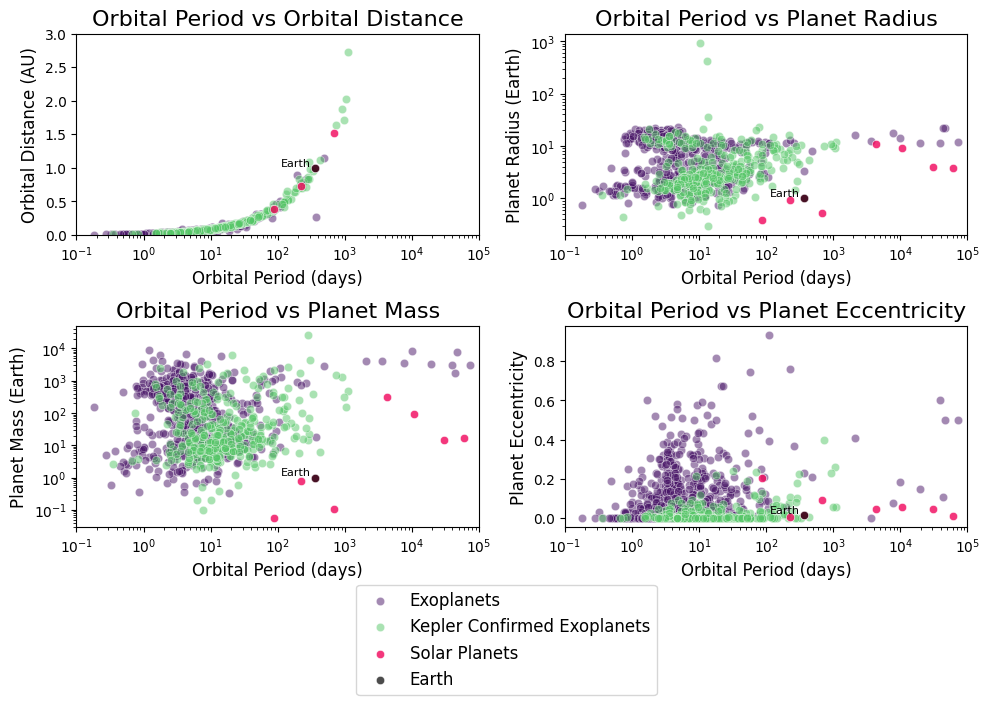

In [46]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

# distance
sns.scatterplot(x='pl_orbper', y='pl_orbsmax', data=exoplanets_nas[exoplanets_nas['kepler_confirmed']==False], label='Exoplanets', alpha=0.5, color='#481567FF', ax=axes[0, 0])
sns.scatterplot(x='pl_orbper', y='pl_orbsmax', data=exoplanets_nas[exoplanets_nas['kepler_confirmed']], label='Kepler Confirmed Exoplanets', alpha=0.5, color='#55C667FF', ax=axes[0, 0])
sns.scatterplot(x='sideralOrbit', y='semimajorAxis_AU', data=solarplanets, label='Solar Planets', alpha=0.8, color='#f0055b', ax=axes[0, 0])

sns.scatterplot(x='sideralOrbit', y='semimajorAxis_AU', data=earth_data, label='Earth', alpha=0.7, color='black', ax=axes[0, 0])
earth_x = earth_data['sideralOrbit'].values[0]
earth_y = earth_data['semimajorAxis_AU'].values[0]
axes[0, 0].text(earth_x - 50, earth_y, 'Earth', color='black', fontsize=8, ha='right', va='bottom')

axes[0, 0].set_xscale('log')
axes[0, 0].set_xlim(10**(-1), 10**5)
axes[0, 0].set_ylim(0, 3)
axes[0, 0].set_title('Orbital Period vs Orbital Distance', fontsize=16)
axes[0, 0].set_xlabel('Orbital Period (days)', fontsize=12)
axes[0, 0].set_ylabel('Orbital Distance (AU)', fontsize=12)

# radius 
sns.scatterplot(x='pl_orbper', y='pl_rade', data=exoplanets_nas[exoplanets_nas['kepler_confirmed']==False], label='Exoplanets', alpha=0.5, color='#481567FF', ax=axes[0, 1])
sns.scatterplot(x='pl_orbper', y='pl_rade', data=exoplanets_nas[exoplanets_nas['kepler_confirmed']], label='Kepler Confirmed Exoplanets', alpha=0.5, color='#55C667FF', ax=axes[0, 1])
sns.scatterplot(x='sideralOrbit', y='radius_earth', data=solarplanets, label='Solar Planets', alpha=0.8, color='#f0055b', ax=axes[0, 1])

sns.scatterplot(x='sideralOrbit', y='radius_earth', data=earth_data, label='Earth', alpha=0.7, color='black', ax=axes[0, 1])
earth_x = earth_data['sideralOrbit'].values[0]
earth_y = earth_data['radius_earth'].values[0]
axes[0, 1].text(earth_x - 50, earth_y, 'Earth', color='black', fontsize=8, ha='right', va='bottom')

axes[0, 1].set_xscale('log')
axes[0, 1].set_xlim(10**(-1), 10**5)
axes[0, 1].set_yscale('log')
axes[0, 1].set_xlabel('Orbital Period (days)', fontsize=12)
axes[0, 1].set_ylabel('Planet Radius (Earth)', fontsize=12)
axes[0, 1].set_title('Orbital Period vs Planet Radius', fontsize=16)

# mass
sns.scatterplot(x='pl_orbper', y='pl_masse', data=exoplanets_nas[exoplanets_nas['kepler_confirmed']==False], label='Exoplanets', alpha=0.5, color='#481567FF', ax=axes[1, 0])
sns.scatterplot(x='pl_orbper', y='pl_masse', data=exoplanets_nas[exoplanets_nas['kepler_confirmed']], label='Kepler Confirmed Exoplanets', alpha=0.5, color='#55C667FF', ax=axes[1, 0])
sns.scatterplot(x='sideralOrbit', y='mass_earth', data=solarplanets, label='Solar Planets', alpha=0.8, color='#f0055b', ax=axes[1, 0])

sns.scatterplot(x='sideralOrbit', y='mass_earth', data=earth_data, label='Earth', alpha=0.7, color='black', ax=axes[1, 0])
earth_x = earth_data['sideralOrbit'].values[0]
earth_y = earth_data['mass_earth'].values[0]
axes[1, 0].text(earth_x - 50, earth_y, 'Earth', color='black', fontsize=8, ha='right', va='bottom')

axes[1, 0].set_xscale('log')
axes[1, 0].set_xlim(10**(-1), 10**5)
axes[1, 0].set_yscale('log')
axes[1, 0].set_xlabel('Orbital Period (days)', fontsize=12)
axes[1, 0].set_ylabel('Planet Mass (Earth)', fontsize=12)
axes[1, 0].set_title('Orbital Period vs Planet Mass', fontsize=16)

# eccentricity
sns.scatterplot(x='pl_orbper', y='pl_orbeccen', data=exoplanets_nas[exoplanets_nas['kepler_confirmed']==False], label='Exoplanets', alpha=0.5, color='#481567FF', ax=axes[1, 1])
sns.scatterplot(x='pl_orbper', y='pl_orbeccen', data=exoplanets_nas[exoplanets_nas['kepler_confirmed']], label='Kepler Confirmed Exoplanets', alpha=0.5, color='#55C667FF', ax=axes[1, 1])
sns.scatterplot(x='sideralOrbit', y='eccentricity', data=solarplanets, label='Solar Planets', alpha=0.8, color='#f0055b', ax=axes[1, 1])

sns.scatterplot(x='sideralOrbit', y='eccentricity', data=earth_data, label='Earth', alpha=0.7, color='black', ax=axes[1, 1])
earth_x = earth_data['sideralOrbit'].values[0]
earth_y = earth_data['eccentricity'].values[0]
axes[1, 1].text(earth_x - 50, earth_y, 'Earth', color='black', fontsize=8, ha='right', va='bottom')

axes[1, 1].set_xscale('log')
axes[1, 1].set_xlim(10**(-1), 10**5)
axes[1, 1].set_xlabel('Orbital Period (days)', fontsize=12)
axes[1, 1].set_ylabel('Planet Eccentricity', fontsize=12)
axes[1, 1].set_title('Orbital Period vs Planet Eccentricity', fontsize=16)

for ax in axes.flat:
    ax.get_legend().remove()
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.67, 0.03), fontsize=12)
plt.tight_layout()
plt.show()


### Why?
> Kepler's Third Law: the squares of the orbital periods of the planets are directly proportional to the cubes of the semi-major axes of their orbits. Kepler's Third Law implies that the period for a planet to orbit the Sun increases rapidly with the radius of its orbit (distance increases $=>$ orbital period increases)